<a href="https://colab.research.google.com/github/SimonTommerup/02805-sgai/blob/main/notebooks/main_notebook3_section_3.2.1_finished.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import networkx as nx
import matplotlib.pyplot as plt
import json
import powerlaw
import scipy
from scipy import integrate
from scipy import stats
from fa2 import ForceAtlas2
from collections import Counter
from tqdm import tqdm
import matplotlib.patches as mpatches


Mount google drive to quickly access network and data


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We can then load the data from the mount and the weighted network generated from this data

In [ ]:
data_path = "drive/MyDrive/SGAI/data_all_merged.csv"
network_path = "drive/MyDrive/SGAI/G_weighted_T_B_removed.gpickle"
df = pd.read_csv(data_path, sep=";")
G_full = nx.read_gpickle(network_path) # Convention: our original weihgted network = G
# The other we'll call B (for backbone)

def extract_decoded_used_subreddits(df): 
  encoded_used_subreddits = np.array(df.used_subreddits)
  used_subreddits_list = []
  for l in encoded_used_subreddits:
    l1 = json.loads(l)
    used_subreddits_list.append(l1)
  return used_subreddits_list



# 1 Motivation
- What is your dataset? **Måske noget ala**
Our presumption is that the subreddits which a user has top-comments on somewhat reflects that user's typical interests. Therefore, we hope to somewhat model common interests between users! 

- Why did you choose this/these particular dataset(s)?
- What was your goal for the end user's experience?

- Criticize how we link users...

# 2 Basic stats. Let's understand the dataset better
- Write about your choices in data cleaning and preprocessing
- Write a short section that discusses the dataset stats (here you can recycle the work you did for Project Assignment A) **But leave network stats (#nodes, #edges degree...) to next section!**

INSPIRATION:

How many of the users has commented on 50 subreddits?

172 users (6.38%) has under 50 comments on other subreddits
k_min: 1, k_max: 50


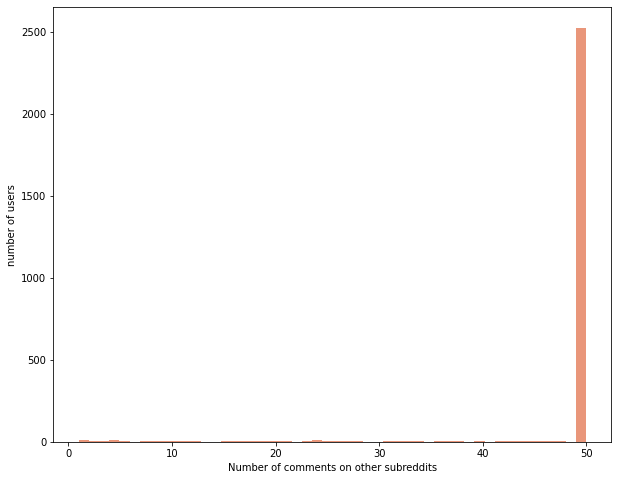

In [ ]:
used_subreddits = np.array(df.used_subreddits)
used_subreddits_list = []
for i, l in enumerate(used_subreddits):
    l1 = json.loads(l)
    used_subreddits_list.append(l1)


lens = [len(li) for li in used_subreddits_list]
limit=50
lens_lows = [len(li) for li in used_subreddits_list if len(li) < limit]


print(f"{len(lens_lows)} users ({round(len(lens_lows)/len(lens)*100,2)}%) has under {limit} comments on other subreddits")


bins = 50
k_min = np.min(lens)
k_max = np.max(lens)
print(f"k_min: {min(lens)}, k_max: {max(lens)}")
count, bins = np.histogram(lens, bins=bins)
plt.subplots(figsize=(10,8))  

# Hist plot
#plt.hist(bins[:len(bins)-1], count, color="darksalmon")
plt.hist(lens, bins, color="darksalmon")

plt.xlabel('Number of comments on other subreddits')
plt.ylabel('number of users')
plt.show()


How diverse are they? (i.e. how many unique subreddits

172 users (6.38%) has under 50 comments on other subreddits
k_min: 1, k_max: 47


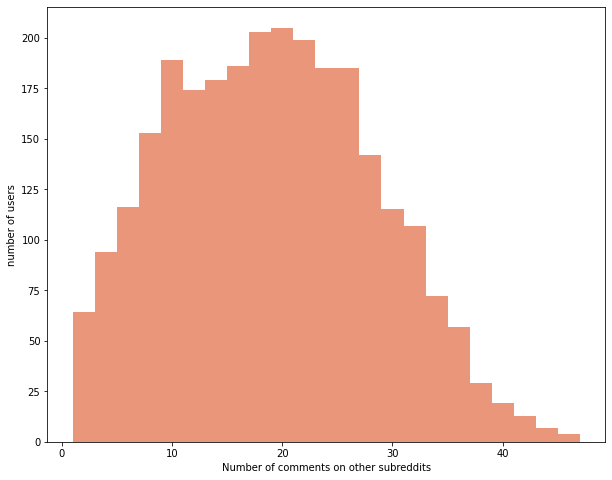

In [ ]:
used_subreddits = np.array(df.used_subreddits)
used_subreddits_list = []
for i, l in enumerate(used_subreddits):
    l1 = json.loads(l)
    used_subreddits_list.append(l1)


lens = [len(set(li)) for li in used_subreddits_list]
limit=50


print(f"{len(lens_lows)} users ({round(len(lens_lows)/len(lens)*100,2)}%) has under {limit} comments on other subreddits")


bins = max(lens)//2
k_min = np.min(lens)
k_max = np.max(lens)
print(f"k_min: {min(lens)}, k_max: {max(lens)}")
count, bins = np.histogram(lens, bins=bins)
plt.subplots(figsize=(10,8))  

# Hist plot
#plt.hist(bins[:len(bins)-1], count, color="darksalmon")
plt.hist(lens, bins, color="darksalmon")

plt.xlabel('Number of comments on other subreddits')
plt.ylabel('number of users')
plt.show()


In [ ]:
# ARGUMENTER FOR...


In [ ]:
from_subreddits = np.array(df.from_subreddit)

bidens = 0
trumps = 0
for i in range(len(from_subreddits)):
  if from_subreddits[i] == "trump":
    if "biden" in used_subreddits[i]:
      bidens+=1
  elif from_subreddits[i] == "biden":
    if "trump" in used_subreddits[i]:
      trumps+=1
  else:
    print("error")


In [ ]:
print(bidens, trumps)

18 8


# 3 Tools, theory and analysis. Describe the process of theory to insight
In this section we analyze the above presented data using network science tools and data analysis strategies.


## 3.1 Creating and analysing the initial networks



**BEMÆRK DENNE SECTION SKAL MÅSKE LIGE SØRGES FOR STEMMER OVERENS MED MOTIVATION OSV.. TING DER KAN SKRIVES HER, KUNNE SIKKERT OGSÅ SKRIVES OVENFOR I 1_MOTIVATION**

As mentioned and discussed in previous sections, we will be investigating active users on the subreddit pages of the two 2020 presidential candidates of USA [Trump](https://www.reddit.com/r/donaldtrump/) and [Biden](https://www.reddit.com/https://www.reddit.com/r/joebiden/). We are interested in examining how users connect based on other subreddits which they have top comments on. 

To do this we can advantageously first first create a bipartite network of users and subreddits. Subsequently we can look at the projection of users, to investigate the users specifically.

Initially we will **Introduction..., then 3.2 then 3.3. then 3.4. (overview!)**.




### 3.1.1 The bipartite network **Consider: building actual bipartite network?**
To describe the bipartite network of users and subreddits, we have 
- $U$, the set of users
- $M$, the two 'main subreddits', which are the [Trump](https://www.reddit.com/r/donaldtrump/) and [Biden](https://www.reddit.com/https://www.reddit.com/r/joebiden/) subreddits.
- $S^u$, the set of subreddits which $u \in U$ has commented on, excluding subreddits in $M$. 
- $S$, the set of all subreddits commented on by all users, ${\bigcup_{u \in U} S^u}$. 

We can assemble this data into a undirected bipartite network $G_{bi}$ with two distjoint sets of nodes $U$ and $S$. A user $u \in U$ is connected to subreddit $s \in S$ if $s \in S^u$. This means that we have a network $G_{bi}$ where a user has a connection to all subreddits which it have commented on. And these subreddits are further connected to every other user, which has also commented on this subreddit. From this point on, we will be using user and node interchangeably.

Note that we do not link users based on the main subreddits as this would otherwise link all users found on the trump-subreddit to each other, and similarly all users found on the biden-subreddit. First of all it would lead towards a biased (high) modularity for separating the network into two communities based on where they were found (trump or biden subreddit). Second, we are interested in investigating which *other* subreddits than the two main ones, the users have in common. Thus, we exclude these when connecting two users.



### 3.1.2 Building a weighted network of users
In order to obtain the network of users, a projection of $G_{bi}$ is considered. To preserve as much information from $G_{bi}$ as possible, links between users are scaled based on the number of common subreddits, which both users have top comments on. 

Specifically, users $u_i, u_j \in U$ are connected with weight equal to the size of $S^{u_i}\cap S^{u_j}$.

We will create the weighted network from an implicit representation of $G_{bi}$, by acessing the data directly from the pandas dataframe

In [ ]:
def get_ids_of_users_with_common_subreddits(user_id, users, used_subreddits):
    users_with_common_subreddits = []
    for other_user_id in range(len(users)):
        if other_user_id != user_id:  # Skip connection to self
            for subr in used_subreddits[user_id]:
                if subr in used_subreddits[other_user_id]:
                    users_with_common_subreddits.append(other_user_id)
                    break
    return users_with_common_subreddits


def get_common_subreddits(user_id, other_user_id, used_subreddits):
    common_subreddits = [subreddit for subreddit in used_subreddits[user_id] if subreddit in used_subreddits[other_user_id]]
    return common_subreddits

  
def create_graph(users, used_subreddits, from_subreddits, commons_2_ignore, n_required_subreddits=1):
    G = nx.Graph()
    # Loop through all users
    for user_id in tqdm(range(len(users))):
        # Add a node for EVERY user in data set 
        G.add_node(users[user_id], from_subreddit=from_subreddits[user_id])

        # Get all other users with atleast one other subreddit in common, 
        other_users_id = get_ids_of_users_with_common_subreddits(user_id, users, used_subreddits)
        for other_user_id in other_users_id:
            # Save all UNIQUE common subreddits as edge property if constraints are satisfied
            common_subreddits = get_common_subreddits(user_id, other_user_id, used_subreddits)
            common_subreddits = list(set(common_subreddits))
            # Remove the two main subreddits (trump and biden) as common subreddit.
            common_subreddits = [subreddit for subreddit in common_subreddits if subreddit not in commons_2_ignore]
            # Only link edges if #common_subreddits > n_required_subreddits
            if len(common_subreddits) >= n_required_subreddits:
                G.add_edge(users[user_id], users[other_user_id], common_subreddits=(common_subreddits), 
                           weight=len(common_subreddits))
    return G


# Extract data to more effeciently loop through it rather than looping through a df
used_subreddits, users, from_subreddits  = extract_decoded_used_subreddits(df), np.array(df.user), np.array(df.from_subreddit)

commons_2_ignore = ['trump', 'biden', ""]

# Create graph
#G_full = create_graph(users, used_subreddits, from_subreddits, commons_2_ignore, n_required_subreddits=1)

Initially, we look closer at the connected components of the networks

In [ ]:
# Extract the largest connected components
CCs = list(nx.connected_components(G_full))

# Print lengths
comps = [list(comp) for comp in CCs]
print("Sizes of the connected components: ", [len(comp) for comp in comps])

Sizes of the connected components:  [2669, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


It reveals that almost the entire network is connected, and only 28 users are disconnected from the rest of the network. These are inspected for which type of subreddits they comment on:

In [ ]:
# Extract users which are not in largest component 
removed_users = [comp[0] for comp in comps if len(comp) == 1]
removed_users_subreddits_with_lengths = []

# Print their info of used subreddits:
for i in range(len(users)):
  if users[i] in removed_users:
    res_string = ""
    for s in set(used_subreddits[i]):
      if len(s) > 10:
        print_s = s[:10] + "..."
      else:
        print_s = s
      res_string+=print_s + ": " + str(len([n for n in used_subreddits[i] if n == s])) + "  "
    removed_users_subreddits_with_lengths.append(res_string)

df_removed_users = pd.DataFrame({'User':removed_users,
                                 'Used subreddits w. counts':removed_users_subreddits_with_lengths
                                })
df_removed_users

,User,Used subreddits w. counts
0,Trouble_Short,trump: 1
1,ArcEchoFive,trump: 4
2,Future_Cup_2762,biden: 50
3,jd33d,biden: 24
4,Connorskath,biden: 1
5,Carmar10,biden: 1
6,hamel7777,biden: 1
7,Words-Always-Matter,biden: 50
8,Popular_Vote_1001,trump: 1
9,Rocco112263,biden: 10 trump: 18


There are some different characteristics of these users.

First, we see that there are some users which are very inactive on reddit with commenting. They've only commented a few times on any subreddit - and of course these are typically biden and trump, as this is the subreddit where we found them initially. And as we do not link according to these two subreddits as mentioned above, they are not linked to any other user

Then, there is a group of users who are somewhat active on a few seemingly less popular subreddits, which none of the other 2697 users have top comments on.

Finally, there are a group of people who are extremely active on the trump and especially biden subreddits, as their top 50 comments only happens to be on these two subreddits. 

As the purpose of this work is to investigate *other* common interests between trump/biden-subreddit users, these persons are not considered in the rest of the analysis. Therefore, we extract the large connected component.



In [ ]:
# Use largest component as network
nodes_of_LC = (max(CCs, key=len))
G = G_full.subgraph(nodes_of_LC).copy()

As supplement to this work, it would be interesting to further investigate and retrieve more data on these very comitted/dedicated trump or biden users who primarily comment on those subreddits.

### 3.1.3 Basic stats and properties of the weighted network



#### 3.1.3.1 Motive


We want an initial impression of the weighted network by calculating some measures
- Number of nodes
- Number of edges
- Min weighted and unweighted degree
- Max weighted and unweighted degree
- Median of weighted and unweighted degrees
- Mode of weighted and unweighted degrees
- Average weight of links
- Average weighted $\langle k_w \rangle$ and unweighted degree $\langle k_u \rangle$
- Density

Additionally, we will look a bit into the node and edge attributes by computing
- Ten most conneted users' used subreddits
- Number of links within each from-subreddit
- Number of links across from-subreddits

These metrics will help determining how to to approach further analysis of the network






#### 3.1.3.2 Tools
For this network, the *unweighted* degree of a user is equal to the number of other users with at least on subreddit in common. Whereas the *weighted* degree is the sum of common subreddits with every other user in the network (i.e. the sum of weights of all links). For example, if three users $u_1, u_2$ and $u_3$ have respectively commented on subreddits,
* $s_1$: "Ask reddit", "Funny cats" and "Conspiracies",
* $s_2$: "Ask reddit", "Funny cats" and "Funny dogs" 
* $s_3$: "Ask reddit" and "Animals are not fun"

then $u_1$ would have degree three, $u_2$ degree three and $u_3$ degree two.



From this definition, measures can be explained,
- *Number of nodes $N$*: the number of reddit users in the network
- *Number of edges $L$*: the number of connections between users, disregarding the weight of the link. This means a link between two users with one subreddit in common, and a link between two other users with 50 subreddits in common contributes equally to this count (with one each). 
- *Min degree*: The minimum degree value of all users
- *Max degree*: The maximum degree value of all users
- *Median*: The value which seperates users into two halfs, one with larger degrees and another with lower degrees.
- *Mode*: The degree value which is most frequent among all users
- *Average weight of links*: The average number of common subreddits between two users.

Furthermore, for $k_{u}$ being the degree of user $u$, and $L_{max}$ being the theoritcal maximum number of links in a network with $N$ nodes (a fully connected network), we have
- *Average degree*: $\langle k \rangle=\frac{1}{N}\sum_{u} k_{u}$
- *Density*: $D=\frac{L}{L_{max}}$

where
$ L_{max} = \frac{N(N-1)}{2} \quad \text{(Barabasi, eq 2.12)}$


#### 3.1.3.3 Results and discussion

All these **basic stats** can easily be computed using the ``networkx``, ``collections`` and ``numpy`` libraries as follows






In [ ]:
# Extract unweighted degrees
degrees = [d for user, d in G.degree(weight=None)]

# Extract all weighted degrees
degrees_weighted = [d for user, d in G.degree(weight='weight')]


# Inserting data into pandas for nice prints
df_stats = pd.DataFrame({'N':[len(G.nodes), len(G.nodes)],
                         'L':[len(G.edges), len(G.edges)],
                         'Min degree':[np.min(degrees), np.min(degrees_weighted)],
                         'Max degree':[np.max(degrees), np.max(degrees_weighted)],
                         'Median degree':[int(np.median(degrees)), int(np.median(degrees_weighted))],
                         'Mode':[Counter(degrees).most_common(1)[0][0], Counter(degrees_weighted).most_common(1)[0][0]],
                         'Avg weight':[1, round(np.mean([w for u, v, w in G.edges(data="weight")]), 2)],
                         '⟨k⟩':[int(round(np.mean(degrees), 0)), int(round(np.mean(degrees_weighted),0))],
                         'D':[round(nx.density(G),2), "-"]
                         }, index=["unweighted", "weighted"])

df_stats


,N,L,Min degree,Max degree,Median degree,Mode,Avg weight,⟨k⟩,D
unweighted,2669,1849355,1,2358,1531,1022,1.00,1386,0.52
weighted,2669,1849355,1,9022,2393,1022,1.94,2690,-


Stats are indicated for when considering the network both as a weighted and a unweighted network. The unweighted network is the weighted network, where all weights are set to one - i.e. users with two, eight or 22 common subreddits are all connected with same weight. 

We see that the unweighted network is very dense with 2669 nodes and nearly two million links. This also appears from the density score of 0.52 - i.e. the unweigted network contains more than half of the edges that a complete network of 2669 nodes would. The dense structure of the network also appears from the unweighted network having a median degree of 1531 and average degree 1386. This means that on average, a user has at least one subreddit in common with 1386 other users, of the total 2669 users. Further, it is seen that the most connected user has a degree of 2358, i.e. has at least one common subreddit with $\frac{2358}{2669}\cdot100\%=88\%$ of users in the network. 

The weighted network is a little more complicated to interpret. Like the unweighted network, it has a minimum degree of 1 - i.e. both networks has users where there in the network exists only one other user with a single subreddit in common. Furthermore, the max degree is now 9022, which means that this user's subreddits appear 9022 times in total among the other users in the network. Hence, this user's subreddits are very common among the other users. Additionally, (and maybe a bit suprising) both network's most frequent degree is 1022. Furthermore, we see that the average degree is 2690. Thus users on average has subreddits, which appears 2690 times among the 2669 users in the network. These facts together with a median degree of 2393 testifies that users generally has many subreddits in common. 

Note that density is not indicated for the weighted network, as this measurement is primary meaningfull for the unweighted network. A somewhat similar measure would be to compute how weighted connections are in the network relative to the corresponding complete network with maximum weight. As we for each user have gathered top 50 comments across all subreddits, users can at maximum link with weight 50 - which is when two users have their top 50 comments on the same 50 unique subreddits. First, we compute the sum of all the weighted connections in the network, $w_{total}$:



In [ ]:
weights_of_all_edges = ([w for u, v, w in G.edges(data="weight")])
print("Sum of weight of all edges: ", f"w_total={sum(weights_of_all_edges)}")

Sum of weight of all edges:  w_total=3589416



Thus, for $L_{max}$ as the theoritcal maximum number of links, each with maximum weight equal to 50, we have:

$$
\frac{w_{total}}{L_{max}\cdot 50} = \frac{w_{total}}{\frac{N(N-1)}{2}\cdot 50} = \frac{3,589,416}{\frac{2669(2669-1)}{2}\cdot 50} = 0.02
$$
``Vil i have denne med hjemmelavede stat med?`` 0.02 tells that weights of links in the network constitutes 2% of what the complete network with maximum weight would have. This number further supports the fact from before, that the network is relatively dense, when we consider what the complete network represents - a network of 2669 users where they have all commented on the same 50 subreddits (with no subreddit appearing twice), among the currently (in 2020) [2.2 million subreddits](https://www.oberlo.com/blog/reddit-statistics). That our network constitutes weights equal 2% of this very unlikely network and users on average have ~2 unique subreddits in common suggests one of two things;
1. either we've found a group of relatively connected users 
2. or (probably more likely) there are some subreddits which are common among most users on subreddit

If 2. is the case, it would be nice to remove these subreddits which are common among most users, and doesn't say much about a (more specific) common interest between two users.






This makes it interesting further investigating the **network properties** - specifically which subreddits the most connected users has top comments on. We extract the ten most connected users with respect to weighted degree: 

In [ ]:
# 5 Most connected users
user_with_degrees = [(user, d) for user, d in G.degree(weight="weight")]
user_with_degrees_sorted = sorted(user_with_degrees, key=lambda x: x[1], reverse=True)[:10]

# Extract users' rows from original df 
top10_users = [user for user, d in user_with_degrees_sorted]
top10_df = df.loc[df['user'].isin(top10_users)].iloc[:, 0:4].copy()
degrees_correct_order = [G.degree(weight="weight")[u] for u in top10_df.user]
top10_df['degree'] = degrees_correct_order
top10_df.sort_values(by=['degree'], inplace=True, ascending=False)

top10_df

,user,from_subreddit,comment,used_subreddits,degree
368,geethanksprofessor,biden,ELI5: Why doesn't it seem like it? Before read...,"[""conspiracy"", ""conspiracy"", ""Bad Cop, No Donu...",9022
2105,prickwhowaspromised,biden,This sounds so dystopian... I can’t wait for B...,"[""Showerthoughts"", ""r/gaming"", ""Cringetopia"", ...",8859
2000,Cannot_go_back_now,biden,N O M A L A R K Y!,"[""funny"", ""OldSchoolCool: History's cool kids,...",8754
1293,perdhapleybot,biden,Anybody else notice that Biden wasn’t the 44th...,"[""World News"", ""Ask Reddit..."", ""r/gaming"", ""A...",8692
1614,semantikron,biden,what a world,"[""/r/videos"", ""Today I Learned (TIL)"", ""I neve...",8567
2325,capoony147,biden,Pack the court.,"[""Ask Reddit..."", ""Ask Reddit..."", ""How do you...",8299
1193,bishslap,biden,Whose body is under the rug? And whose frilly...,"[""Today I Learned (TIL)"", ""MadeMeSmile"", ""Poli...",8160
1843,Mecmecmecmecmec,trump,We’ll see how interested he is if he asks a qu...,"[""/r/PublicFreakout"", ""No such thing as stupid...",8155
416,TAU_doesnt_equal_2PI,biden,You could really tell every time George had th...,"[""All things Trashy!"", ""Space Discussion"", ""/r...",7877
420,raddits,biden,Big energy,"[""Ask Reddit..."", ""Ask Reddit..."", ""Blunder Ye...",7854


It quickly appears that it is mostly biden users which are the most connected to the rest of the users. And additionally, that e.g. "Ask Reddit..." is common for some of the top users. 

To better see the *unique* subreddits of the most connected users, we extract 

In [ ]:
top10_used_subreddits = np.array(top10_df['used_subreddits'])

# Remember: we need to decode json objects!
top10_unique_used_subreddits = [list(set(json.loads(subreddits))) for subreddits in top10_used_subreddits]

# Add empty lists for putting into df
for s in top10_unique_used_subreddits:
  while len(s) < len(max(top10_unique_used_subreddits, key=len)):
    s.append("")

# Add to a df for visualization
df_top_reddits = pd.DataFrame()
for i, user in enumerate(top10_users[:3]):
  df_top_reddits[user]=top10_unique_used_subreddits[i]


df_top_reddits

,geethanksprofessor,prickwhowaspromised,Cannot_go_back_now
0,Let's hope you didn't vote for the pedo,r/teenagers,Get Motivated!
1,"Sadly, this is not the Onion.","Sadly, this is not the Onion.",Insane People on Facebook
2,What Could Possibly Go Wrong?,IT'S TIME TO STOP,Reddit Pics
3,"TumblrInAction: O Toucan, Where Art Thou?",ImaginarySliceOfLife: Art that showcases aspec...,funny
4,People who actively act like a piece of shit,Insane People on Facebook,"All news, US and international."
5,Reddit Pics,Humans just being bros,Android
6,Reddit Science,Idiots In Cars,Ask Reddit...
7,funny,Pokémon: Gotta Catch ’Em All!,Movie News and Discussion
8,"All news, US and international.",funny,A gallery of inexplicable stupidity
9,Ask Reddit...,"All news, US and international.",/r/Technology


Several things can be observed from the top connected users' ``used_subreddits``. They all seem to have commented on some subreddits, which are very large and common among many reddit users. Just to mention a few, "[Ask Reddit...](https://www.reddit.com/r/AskReddit/)", "[r/videos](https://www.reddit.com/r/videos/)" and "[funny](https://www.reddit.com/r/funny/)" all have more than 24 million members (**people who have commented on the subreddit?)**. Also, there seem to be some political subreddits, e.g. "[Conservative](https://www.reddit.com/r/Conservative/)" with 500 thousands members and [Politics](https://www.reddit.com/r/politics/) with 8 million. Finally, there also seem to be some pretty specific (and maybe less common) subreddits like [It's Mueller Time!](https://www.reddit.com/r/The_Mueller/)

Lastly, we will look how much users are connected to other users with same and different ``from_subreddit``. We sum the weights of links between nodes which have 
1. both "trump" as ``from_subreddit``
2. both "biden" as ``from_subreddit``
3. "trump" as the 1st ``from_subreddit`` and "biden" as the 2nd
4. "biden" as the 1st ``from_subreddit`` and "trump" as the 2nd

If the network is random, ~50% of weights will fall into the first two categories (1, 2) and 50% into the last to (3,4):

In [ ]:
# Without weight
within_trump = 0
within_biden = 0
crosses = 0


for u, v, w in G.edges(data="weight"):
    u_from = G.nodes[u]['from_subreddit']
    v_from = G.nodes[v]['from_subreddit']

    if u_from == "trump" and v_from == "trump":
        within_trump+=1*w
    elif u_from == "biden" and v_from == "biden":
        within_biden+=1*w
    elif u_from == "trump" and v_from == "biden":
      crosses+=1*w
    elif u_from == "biden" and v_from == "trump":
      crosses+=1*w
    else:
      print("ERROR")
    
total_w = sum(weights_of_all_edges)

print("within any (category 1 and 2): ", round((within_biden + within_trump)/total_w,2))
print("crosses (category 3 and 4): ", round(crosses/total_w,2))


within any (category 1 and 2):  0.57
crosses (category 3 and 4):  0.43


At a first glance, we see that users tend to be slightly more connected to other users, who wrote on the same ``from_subreddit``, as only 43% of the weight in links seem to go accross the ``from_subreddit``. In future sections, it will be further investigated whether this suggest a community structure (**or if this difference is just noise?**.)


### 3.1.4 Degree distribution and Visualizing the weighted network

#### 3.1.4.1 Motive


#### 3.1.4.2 Tools
Force atlas.. Degree dist...


#### 3.1.4.3 Results and discussion


In [ ]:
# Calculate position with the ForceAtlas2 algorithm
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=1.0,

                        # Log
                        verbose=True)
pos = forceatlas2.forceatlas2_networkx_layout(G=G, pos=None, iterations=2000)

100%|██████████| 2000/2000 [02:12<00:00, 15.08it/s]

BarnesHut Approximation  took  22.23  seconds
Repulsion forces  took  37.85  seconds
Gravitational forces  took  0.26  seconds
Attraction forces  took  67.88  seconds
AdjustSpeedAndApplyForces step  took  1.30  seconds


In [ ]:
# Make colors and node sizes for network
def node_size_and_colouring(network, color_trump, color_biden):
    color_map = []
    node_sizes = []
    # out degrees:
    max_deg = max([(v) for (e,v) in network.degree])

    for name in network.nodes:
        node_sizes.append((network.degree([name])[name]+1)/10)

        if network.nodes[name]['from_subreddit'] == 'trump':
            color_map.append(color_trump)
        elif network.nodes[name]['from_subreddit'] == 'biden':
            color_map.append(color_biden)
        else:
            print("Error")
    return color_map, node_sizes

color_map, node_sizes = node_size_and_colouring(G, "crimson", "royalblue")

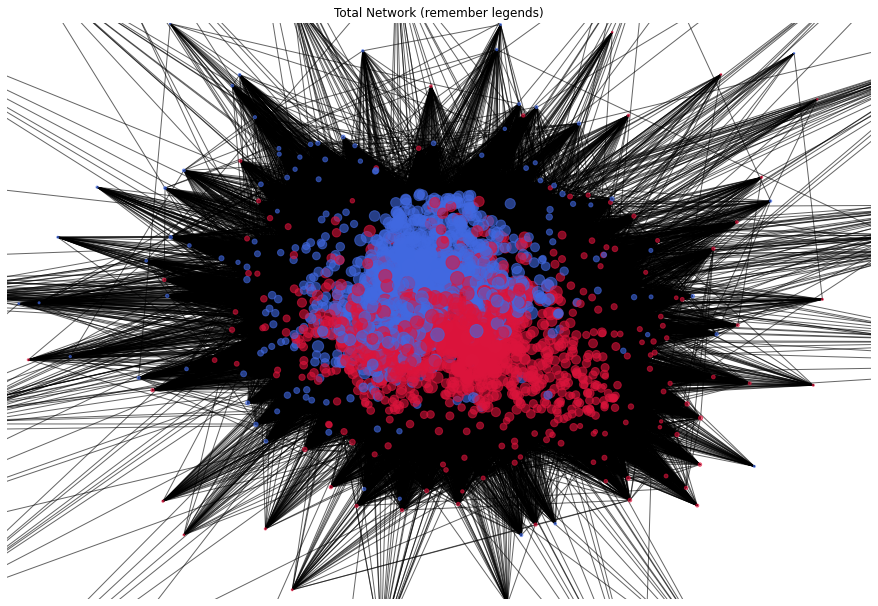

In [ ]:
fig = plt.figure(figsize=(12, 8))
nx.drawing.nx_pylab.draw(G, node_color=color_map, node_size=node_sizes, with_labels=False, edge_color='black', alpha=.6)
plt.title("Total Network (remember legends)")
plt.ylim((-0.3, 0.3))
plt.xlim((-0.3, 0.3))
plt.show()

TODO: 
- Present basic NETWORK stats we got from Project A (#Edges, #nodes, avg/min/max degree)
- Plot the network with (possibly with current classification = from_subreddit)
- Degree dist

## 3.2 Extracting networks of interest and classifying users

### 3.2.1 Extracting the "backbone" of the user network
- Motive: "As we saw from introduction - weighted is very dense... Might be able to extract to more informative!" 
- Tools: "Works by applying disperse filters, defined by "...
- Results: "Resulting network is..." (#Edges, #nodes, avg/min/max degree) + PLOT
- Discussion: " Will be used as comparison to weighted, to see which one gives more information"

### 3.2.1.1 Motivation

We saw in section 3.1.1.1 that the weighted network was very dense. With such an overwhelming number of connections there will arguably be a lot of redundant information (Serrano 2009, 6483). 

Therefore it would be a good idea to attempt to reduce the complexity of the network while preserving the key features and information contained in the network. This can be seen as a network science analogy to performing principal component analysis on very high dimensional feature spaces known from machine learning. 

One immediate idea could be to preserve links having a certain weight and stripping links under this threshold from the network. However this kind of global thresholding would mean that we simply lose the information of the links with a weight under the somewhat arbitrary global threshold value (Serrano 2009, 6483).

A way to reduce the complexity in a more careful way is presented in the article Extracting the multiscale backbone of complex weighted networks (Serrano 2009). The core idea is to preserve the edges that are statistically significant for the network model in relation to a null hypothesis model where the weights are randomly uniform. A more detailed explanation will be provided in the following subsection. 


### 3.2.1.2 Developing the disparity filter tool set
We want to develop a so-called disparity filter to use as a tool for the complexity reduction. To develop this tool, the first thing needed is a way to let each node $i$ in the network assign a relative importance $p$ to its links:

$$
p_{ij} = \frac{w_{ij}}{\sum_j w_{ij}} \quad \text{for} \quad i \in I
$$

Thus for each link $j$ that a node has the formula above expresses the proportion of the nodes total weight that link $j$ carries. This allows us to express the level of local heterogenity or disparity in link weights (Serrano 2009, 6484). The next step is to consider what the disparity for a nodes weights should be expected to look like if the normalized weights $p_{ij}$ were placed uniformly random between 0 and 1. This means our null hypothesis is:

$$
\mathbf{H_0}: \text{For a node i with degree k,} \quad p_{ij} \sim U(0,1)
$$

Now we can take a certain node with degree $k$. Then we place $k-1$ points in the interval $[0,1]$ with uniform probability. 

The lengths of the resulting subintervals can be seen as the $p_{ij}$. They will represent the expected values of the $k$ normalized weights if they were randomly drawn from a uniform distribution (Serrano 2009, 6484).

The probability distribution function for one of the values $p_{ij}$ taking a specific value $x$ is given by:

$$
p(x)dx = (k-1)(1-x)^{k-2}dx  \quad \text{(Serrano 2009, eq. 1)}
$$

It can be seen that this probability is dependent on the degree of the node in question. For example, for a node with two links, $k=2$ it can be seen that $p(x)dx=1dx$, which means that the single point dividing the interval into two lengths has uniform probability in the interval. 

For each node $i$ with links $j \in J$ this means, if the null hypothesis, $\mathbf{H_0}$ is true, that the probability of observing a normalized weight with a value as extreme or more extreme than $p_{ij}$ can be calculated by:

$$
\alpha_{ij} = 1 - (k-1)\int_0^{p_{ij}}(1-x)^{k-2}dx \quad \text{(Serrano 2009, eq. 2)} 
$$

A certain $p$ or $\alpha$-value can then be set to form a criterion for when a link is significant. This means a link $j$ is significant if 

$$
\alpha_{ij} < \alpha
$$

Again to provide a simple example with node degree $k=2$, it can be seen that the calculation of $\alpha_{ij}$ simplifies to $\alpha_{ij} = 1 - p_{ij}$. When $p_{ij}$ is close to 1, then link $j$ carries a lot of the total weight of the links connecting to node $i$ and so it should be an important link for node $i$. This is reflected by $\alpha_{ij}$ which is consequently close to zero, meaning that it would be statistically significant to some level $\alpha$.   

The function `disparity_filter` below implements the calculation of $\alpha$-values for every link weight for every node in $G$ and rebuilds $G$ with an additional edge attribute containing the $\alpha$-value:


In [ ]:
def disparity_filter(G):
    """
    References:
    python-backbone-network, https://github.com/aekpalakorn/python-backbone-network
    M. A. Serrano et al. (2009) Extracting the Multiscale backbone of complex weighted networks. PNAS, 106:16, pp. 6483-6488.
    """
    Gdf = nx.Graph()
    for idx, i in enumerate(G):
        if (idx + 1) % 500 == 0:
            print(f"Node {idx+1} of {len(G)}")

        # Node degree
        k = len(G[i])

        # Save node with attribute
        Gdf.add_node(i, from_subreddit=G.nodes[i]["from_subreddit"])

        if k > 1: # (Serrano 2009, footnote, p. 6485)
            
            # Node strength:
            s_i = sum( G[i][j]["weight"] for j in G[i])
            
            for j in G[i]:

                # Disparity Filtering
                w_ij= G[i][j]["weight"]
                p_ij = w_ij / s_i 
                alpha_ij = 1 - (k-1) * scipy.integrate.quad(lambda x: (1-x)**(k-2), 0, p_ij)[0]

                # Save neighbor node with attribute
                Gdf.add_node(j, from_subreddit=G.nodes[j]["from_subreddit"])

                # Saving edge with alpha-value
                Gdf.add_edge(i, j, common_subreddits=G[i][j]["common_subreddits"], weight=w_ij, alpha=alpha_ij)

    return Gdf

With the $\alpha$-values in place the function `alpha_cut` rebuilds G with only significant nodes. Note that the `try`-`except` statement is due to the fact that the $\alpha$-values are only assigned for nodes with a degree larger than 1. 

This is in turn due to a slight technicality of the algorithm. If a node $i$ with degree $k_i = 1$ is connected to a node $j$ of degree $k_j > 1$, then the significance of the link is determined from the threshold on node $j$ (Serrano 2009, 6485, footnote *) which is implemented above as simply not performing a the $\alpha$-value calculation for nodes with degree 1, thus it is possible that a node does not have the `alpha`-attribute. If a node $i$ does not have the `alpha`-attribute, the value of the node $i$ alpha is set to 1, which means that the link will fail the significance test and its fate will then depend on the threshold of connected node $j$.

In [ ]:
def alpha_cut(G, alpha_level=0.05):
    """
    python-backbone-network, https://github.com/aekpalakorn/python-backbone-network
    M. A. Serrano et al. (2009) Extracting the Multiscale backbone of complex weighted networks. PNAS, 106:16, pp. 6483-6488.
    """
    D = nx.Graph()
    for u, v, attributes in G.edges.data(data=True):
        try:
            alpha = attributes["alpha"]
        except KeyError:
            alpha = 1
        
        if alpha < alpha_level:
            D.add_node(u, from_subreddit=G.nodes[u]["from_subreddit"])
            D.add_node(v, from_subreddit=G.nodes[v]["from_subreddit"])
            cs = attributes["common_subreddits"]
            w = attributes["weight"]
            D.add_edge(u,v, common_subreddits=cs, weight=w)
    return D

In [ ]:
path = "/content/G_weighted_T_B_removed.gpickle"
G = nx.read_gpickle(path)

Ntot = len(G.nodes)
Ltot = len(G.edges)
Wtot = sum([weight for u,v,weight in G.edges.data(data="weight")])


The authors argue that this method will work best if their is a heigh level of weight heterogeneity at both a global and local scale (Serrano 2009, 6487). On the global level this would mean that the weights present in the network takes a lot of different values. On the local level the following measure of heterogeneity can be applied on each node $i$:

$$
kY_i(k) = k \sum_j p_{ij}^2 \quad \text{(Serrano 2009, eq. 3)}
$$

In the equation above it can be seen that if the weights of a node are perfectly homogeneous, then all the normalized weights $p_{ij}$ are equal and $kY_i(k) = 1$. 

This indicates why the method will node work in a network thats too high a degree of homogeneity: It will be increasingly difficult to set a significance level that will be able to actually remove links. 

Conversely, in the case of perfect heterogeneity where only one $p_{ij} = 1$ meaning that this weight accounts for all the weight, then $kY_i(k) = k$. 

The function `local_heterogeneity` below implements equation 3:

In [ ]:
def local_heterogeneity(G):
    nodes_by_ascending_degree = sorted(G.degree, key=lambda x: x[1], reverse=False)
    upsilon = []
    degrees = []
    for tup in nodes_by_ascending_degree:
        i = tup[0]
        k = tup[1]
        degrees.append(k)

        # Calculate sum of weights of incident edges
        s_i = sum(G[i][j]["weight"] for j in G[i])

        # Calculate square on each normalized weight
        pij_sq = [ (G[i][j]["weight"] / s_i)**2 for j in G[i]]

        # Sum of the squares:
        sum_pij_sq = sum(pij_sq)

        # Upsilon(i, k)
        upsilon.append( k * sum_pij_sq )
    
    return upsilon, degrees

### 3.2.1.3 Experimentation

First we will asses both the global distribution of weights and the local level of heterogeneity in the following plots:

In [ ]:
weights = []
for u, v, weight in G.edges.data(data="weight"):
  weights.append(weight)

upsilon, degrees = local_heterogeneity(G)

In [ ]:
n_bins = 17
weight_counts, bins = np.histogram(weights, bins=n_bins)
xbins=bins[:len(bins)-1]
wprobs = weight_counts / sum(weight_counts)

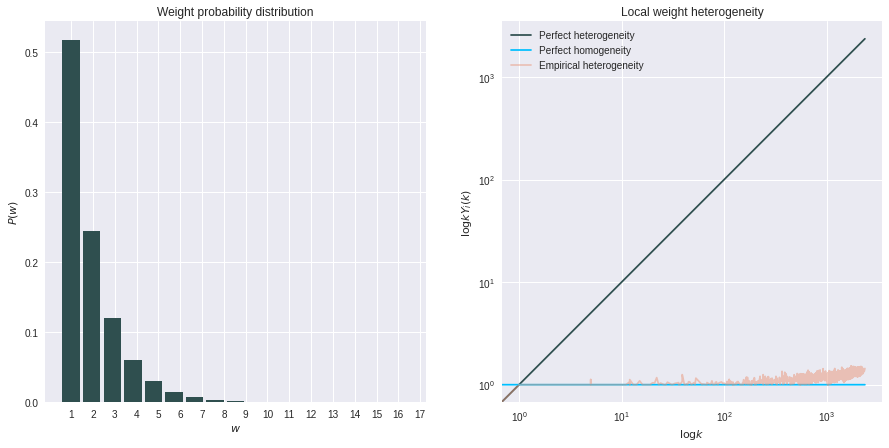

In [ ]:
plt.style.use("seaborn")
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
ax0.bar(xbins, wprobs, color="darkslategray")
ax0.set_xticks(list(set(weights)))
ax0.set_title("Weight probability distribution")
ax0.set_xlabel("$w$")
ax0.set_ylabel("$P(w)$")
ax1.plot(degrees, degrees, color="darkslategray")
ax1.plot(degrees, np.ones(len(degrees)), color="deepskyblue")
ax1.plot(degrees, upsilon, color="darksalmon", alpha=0.5)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_title("Local weight heterogeneity")
ax1.set_xlabel("$\log k$")
ax1.set_ylabel("$\log kY_i(k)$")
ax1.legend(["Perfect heterogeneity", "Perfect homogeneity", "Empirical heterogeneity"])
fig.show()

From the global weight probability distribution, it can se seen that almost the entire probability mass is placed for weights less than 6. This means that on a global level the weights are not very heterogeneous as most weights are small. 

From the plot of the local weight heterogeneity, it can be seen that the local heteregeneity is also relatively small. 
However it can be seen that the heterogeneity seems to increase for nodes that have a high degree. This means that we will be able to apply the method with some success if we use relatively small values of $\alpha$.

Also it will likely mean that the most removal of links will happen at nodes that have a high degree, because the heterogeneity is generally highest in these regions of the network. 

Next we will need to consider at which significance level we should perform the removal of links. To this end we can look at the fraction of preserved nodes $N_B / N_{TOT}$ as a function of the fraction of preserved links $L_B / L_{TOT}$ and as a function of the fraction of preserved weight $W_B / W_{TOT}$. 

First the network is filtered with the disparity filter, assigning an $\alpha$-value to all the links in $G$:

In [ ]:
Gdf = disparity_filter(G)

Node 500 of 2697
Node 1000 of 2697
Node 1500 of 2697
Node 2000 of 2697
Node 2500 of 2697


In the following `for`-loop we will perform a search through 50 $\alpha$-values in the range $[0.01, 0.5]$. In each iteration the function `alpha_cut` builds a new graph only containing links that are significant. 

In [ ]:
# Authors recommend alpha values in range [0.01, 0.5]
alpha_levels = np.arange(0.01, 0.51, 0.01)

xvals_edgefraction = []
xvals_weightfraction = []
yvals_nodefraction = []
for alpha_level in alpha_levels:
    B = alpha_cut(Gdf, alpha_level=alpha_level)

    # Nodes and links preserved
    Nb = len(B.nodes)
    Lb = len(B.edges)

    # Weight preserved
    Wb = sum([weight for u,v,weight in B.edges.data(data="weight")])

    xvals_edgefraction.append(Lb / Ltot)
    xvals_weightfraction.append(Wb / Wtot)
    yvals_nodefraction.append(Nb / Ntot)

The lists holding the values will be plotted shortly. Before that we define the function `global_threshold` which implements the immediate approach mentioned above. The function `global_threshold` creates a new graph from $G$ that only contains the nodes connected by links carrying weights over a given global threshold value. 

In [ ]:
def global_threshold(G, threshold):
    GT = nx.Graph()
    for u,v,weight in G.edges.data(data="weight"):
        if weight >= threshold:
            GT.add_edge(u,v, weight=weight)
    return GT

Above we increased the $\alpha$-values gradually decreasing the level of statistical significance and consequently allowing more links to stay in the network. For the global threshold we instead decrease the global threshold from the maximum weight 17 in the network to a threshold of 1 which means that we gradually allow more links: 

In [ ]:
max_weight = max([weight for u,v,weight in G.edges.data(data="weight")])
xvals_GT_edgefraction = []
xvals_GT_weightfraction = []
yvals_GT_nodefraction = []

for threshold in np.linspace(max_weight, 1, 50):
    GT = global_threshold(G, threshold=threshold)

    # Nodes and links preserved
    Ngt = len(GT.nodes)
    Lgt = len(GT.edges)

    # Weight preserved
    Wgt = sum([weight for u,v,weight in GT.edges.data(data="weight")])

    xvals_GT_edgefraction.append(Lgt / Ltot)
    xvals_GT_weightfraction.append(Wgt / Wtot)
    yvals_GT_nodefraction.append(Ngt / Ntot)

Now everything is in place to create the plots:

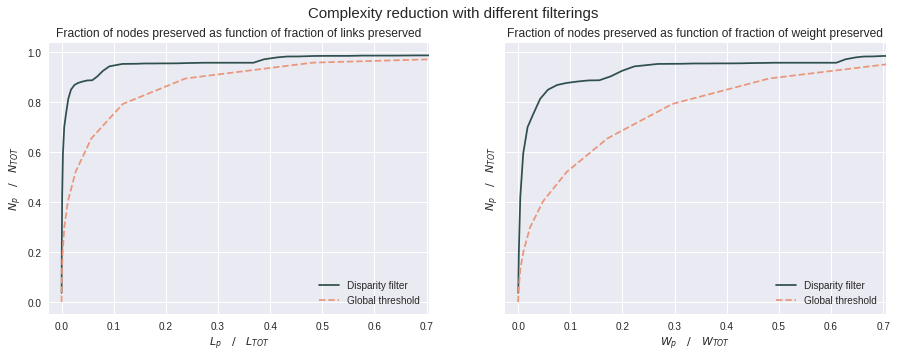

In [ ]:
plt.style.use("seaborn")
ys = [yvals_nodefraction, yvals_GT_nodefraction]
xs = [xvals_edgefraction,xvals_weightfraction, xvals_GT_edgefraction, xvals_GT_weightfraction]

meth_0 = "Disparity filter"
meth_1 = "Global threshold"
desc_0 = "Fraction of nodes preserved as function of fraction of links preserved"
desc_1 = "Fraction of nodes preserved as function of fraction of weight preserved"
ylabel = "$N_p \quad / \quad N_{TOT}$"
xlabels = ["$L_p \quad / \quad L_{TOT}$", "$W_p \quad / \quad W_{TOT}$"]
m = [meth_0, meth_1]
d = [desc_0, desc_1]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5), sharey=True)

for idx, ax in enumerate(axes):
  ax.plot(xs[idx], ys[0],color="darkslategray", label=meth_0)
  ax.plot(xs[idx+2], ys[1], "--", color="darksalmon", label=meth_1)
  ax.set_xlim(-0.025, max(xs[0]))
  ax.set_title(d[idx])
  ax.set_ylabel(ylabel)
  ax.set_xlabel(xlabels[idx])
  ax.legend()

fig.suptitle("Complexity reduction with different filterings", fontsize=15)
fig.show()

From the plots it can be seen that we are able to greatly decrease the number of links and consequently a large amount of weight while keeping a lot of the nodes. Also it can be seen that the disparity filter is able to preserve a higher fraction of nodes with lower fractions of links and weights. This means that it is a worthwhile choice to use the disparity filter instead of the simple global thresholding filter as we clearly keep more information with fewer links. 

From dimensionality reduction techniques such as principal component analysis it is customary to look at so-called scree plots to decide on a number of features that to some extent explains most of the variance in a data set. This would mean to select the number of features that gives rise to the steepest slopes in the fraction of variance explained by including them as most information is held in these features.  

If we follow this intuition and apply it to the present case of network analysis, it seems like a good choice to select an $\alpha$-values that gives us the most nodes for the cost of least links as this will preserve the most information and the least redundant links.

Upon visual inspection of the plots it seems that an $\alpha$-value of around 0.09 will preserve around 85 \% of the nodes will retaining only around 2.5 \% of the links. Therefore we choose $\alpha = 0.09$ to perform the $\alpha$-cut on $G$, hence creating our backbone network $B$:

In [ ]:
B = alpha_cut(Gdf, alpha_level=0.09)
print("Fraction of nodes preserved:", len(B.nodes)/Ntot)
print("Fraction of links preserved:", len(B.edges)/Ltot)

Fraction of nodes preserved: 0.8694846125324435
Fraction of links preserved: 0.024555047570639494


The basic statistics of the resulting weighted network $B$ is presented below in comparison with the original weighted network $G$ which was first presented in section 3.1.3.3. 

In [ ]:
CCs = list(nx.connected_components(G))
nodes_of_LC = (max(CCs, key=len))
G = G.subgraph(nodes_of_LC).copy()

Bdegw = [d for user, d in B.degree(weight="weight")]
Gdegw = [d for user, d in G.degree(weight="weight")]

def avg_weight(network):
  return round(np.mean([w for u, v, w in network.edges(data="weight")]), 2)


df_stats = pd.DataFrame({'N':[len(G.nodes), len(B.nodes)],
                         'L':[len(G.edges), len(B.edges)],
                         'Min degree':[np.min(Gdegw), np.min(Bdegw)],
                         'Max degree':[np.max(Gdegw), np.max(Bdegw)],
                         'Median degree':[int(np.median(Gdegw)), int(np.median(Bdegw))],
                         'Mode':[Counter(Gdegw).most_common(1)[0][0], Counter(Bdegw).most_common(1)[0][0]],
                         'Avg weight':[avg_weight(G),avg_weight(B)],
                         '⟨k⟩':[int(round(np.mean(Gdegw), 0)), int(round(np.mean(Bdegw),0))]
                         }, index=["G", "B"])

df_stats

,N,L,Min degree,Max degree,Median degree,Mode,Avg weight,⟨k⟩
G,2669,1849355,1,9022,2393,1022,1.94,2690
B,2345,45411,3,4592,107,3,5.91,229


The most notable change is the reduction by a factor of 40 of the links in the network. Along with this change there are several other things to notice in the table above:

1.   The minimum degree has shifted to a value of 3 which means that the user with least interests in common with other user's now has three such interests.


2.   There has been a shift in the other direction for the maximum degree where it can be seen that the maximum degree is approximately halved. This is likely because many of the links which was removed was highly popular subreddits which linked many, many users with a superficial, low weight and accordingly a lot of these connections is lost for the most connected node. 

3. The reasoning from point 2 is probably also the reason why the average weighted degree has gone from 2690 to 229. 

These effects is considered positive as the network can now be seen as more focused with regards to spotting interest communities in the network. 

In this way, point 1 this can be seen as a "lower bound" for how weak or shallow connections between users we now consider. Meanwhile point 2 and 3 can be interpreted as removing a lot of noise from the very connected nodes and the remaining nodes in general. Noise in this respect will be that some subreddits like general advice subreddits and news subreddits are very common interests, so by their exclusion by the filtering we don't lose too much information.  

Also:

4. We see that the average weight of the remaining links has increased, meaning that the reduction in links must have happened mainly on links with relatively low weights in the network. 

As this is the first indication that confirms the assumptions in the reasoning of this section, we want to back it up by exploring which links were removed. Consider the following bar plots, where the distributions of respectively the weights removed the weights that were kept by `alpha_cut` are shown:




In [ ]:
def about_alpha_cut(G, alpha_level=0.05):
    cut_weight = []
    cut_reddit = []
    cut_red_append = []

    stay_weight = []
    stay_reddit = []
    for idx, (u, v, attributes) in enumerate(G.edges.data(data=True)):
        try:
            alpha = attributes["alpha"]
        except KeyError:
            alpha = 1
        if alpha < alpha_level:
            stay_weight.append(attributes["weight"])
            stay_reddit += attributes["common_subreddits"]
        elif alpha >= alpha_level:
            cut_weight.append(attributes["weight"])
            cut_reddit += attributes["common_subreddits"]
            cut_red_append.append(attributes["common_subreddits"])

    return cut_weight, cut_reddit, cut_red_append, stay_weight, stay_reddit

cw, cr, cra, sw, sr = about_alpha_cut(Gdf, alpha_level=0.09)

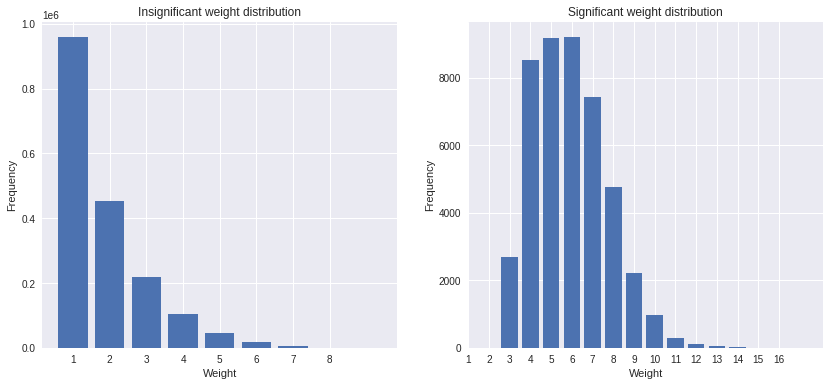

In [ ]:
def discrete_bar(weight_list):
  counter = Counter(weight_list)
  bins = [k for k in counter.keys()]
  counts = [v for v in counter.values()]
  return [bins, counts] 

bc = [discrete_bar(cw), discrete_bar(sw)]
titles = ["Insignificant weight distribution", "Significant weight distribution"]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
for idx, ax in enumerate(ax):
  ax.bar(bc[idx][0], bc[idx][1])
  ax.set_title(titles[idx])
  ax.set_ylabel("Frequency")
  ax.set_xlabel("Weight")
  ax.set_xticks([x for x in range(1, max(bc[idx][0]))])


We see that almost a million of the insignificant links that were removed was links with a weight of 1. Also it can be see that the significant weights looks almost Poisson distributed around the mean of $\approx 6$ and it can be noticed that there are simply no weights less than 3 among the significant weights. 

In the code-block below we will consider which subreddits appeared most commonly in respectively insignificant and significant links:

In [ ]:
counter_cr = Counter(cr)
counter_sr = Counter(sr)
print("Most common subreddits at insignificant links: ")
print(counter_cr.most_common(10))
print("\n Most common subreddits at significant links: ")
print(counter_sr.most_common(10))

Most common subreddits at insignificant links: 
[('Ask Reddit...', 523921), ('Politics', 507271), ('All news, US and international.', 210530), ('Reddit Pics', 171405), ('World News', 162303), ('Conservative', 145589), ('funny', 118307), ('Today I Learned (TIL)', 97162), ('/r/PublicFreakout', 89264), ('A subreddit for cute and cuddly pictures', 55940)]

 Most common subreddits at significant links: 
[('Ask Reddit...', 22614), ('Politics', 15482), ('Reddit Pics', 14950), ('All news, US and international.', 14255), ('World News', 12633), ('funny', 11488), ('Today I Learned (TIL)', 10718), ('/r/PublicFreakout', 7316), ('.gifs - funny, animated gifs for your viewing pleasure', 5573), ('/r/videos', 5147)]


It can clearly bee seen that the most common subreddits at insignificant links are very general and broadly appealing subreddits like "Ask Reddit", "Polictics" and "World News" as we expected a few text blocks above. 

There is however also the subreddit "Conservative" which name indicates that it may not be for everyone. Since an overwhelming amount of the removed links had weight 1, there is a fair probability that the links holding this subreddit connected Trump-minded people on a superficial level. However, had we discovered a bond between Trump-supporters and American conservatism this may not have been too informative regardless. 

Meanwhile it can be seen that this is also the case for the significant links and the two lists are almost identical. This will be considered to be a positive observation as the network can be seen to have preserved a distinctive quality after the disparity filtering, namely that the popular subreddits should be popular.

In [ ]:
def subreddit_cut_with_weight(cutweights, cutreddits, pattern, weights):
    count = 0
    for idx, w in enumerate(cutweights):
        if w in weights:
            for elem in cutreddits[idx]:
                if pattern in elem:
                    count += 1

    return count

ar = subreddit_cut_with_weight(cw, cra, "Ask Reddit", [1])
an = subreddit_cut_with_weight(cw,cra, "All news, US and international.", [1])
cn = subreddit_cut_with_weight(cw, cra, "Politics", [1])

print(f"r/Ask Reddit   removed in links with weight 1: {ar}")
print(f"r/All news, US and international removed in links with weight 1: {an}")
print(f"r/Politics removed in links with weight 1: {cn} \n")
print(f"Fraction of removals accounted for: {(ar+an+cn)/(len(G.edges)-len(B.edges))}")

r/Ask Reddit   removed in links with weight 1: 185013
r/All news, US and international removed in links with weight 1: 38235
r/Politics removed in links with weight 1: 220803 

Fraction of removals accounted for: 0.24615564562979783


The code block above counts the number of times certain very general subreddits has been removed as a shallow connection of weight 1 and these removals can be seen to account for about 25 \% of the total links removals. Thus this also seems to support what we expected from looking at the basic statistics of the filtered network. 

Next we can consider the resulting weighted degree distribution for $B$. It turns out that it is a whole other picture than what we observed in section 3.1.4.3:

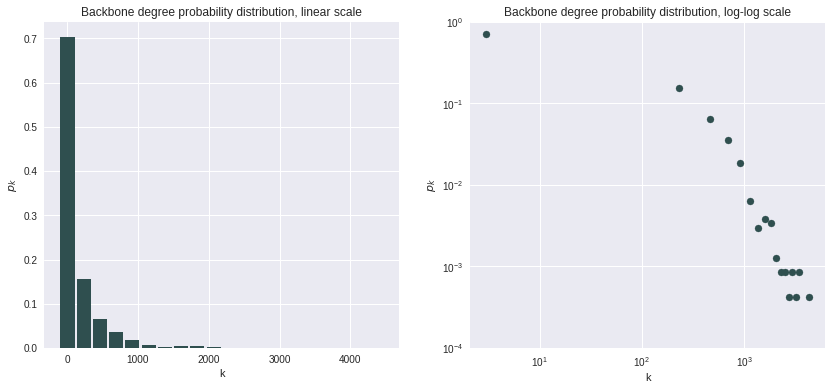

In [ ]:
n_bins = 20
count, bins = np.histogram(Bdegw, bins=n_bins)
xbins=bins[:len(bins)-1]
probs = count/sum(count)

fig, ax = plt.subplots(1,2, figsize=(14,6))
ax[1].set_xscale("log")
ax[1].set_yscale("log")
ax[1].set_ylim(1e-4,1)
ax[0].bar(xbins, probs, 200, color="darkslategray")
ax[1].scatter(xbins, probs, color="darkslategray")
ax[0].set_title("Backbone degree probability distribution, linear scale")
ax[1].set_title("Backbone degree probability distribution, log-log scale")

for a in ax:
  a.set_xlabel("k")
  a.set_ylabel(r"$p_k$")

fig.show()

From the degree distribution on both the linear and the log-log-scale it seems that the resulting weighted degree distribution appears to look like a scale-free network which can be seen as the distributions appears to follow a power-law distribution. 

On the linear scale it is seen clearly that the vast majority of nodes have a low weighted degree and there are some heavily connected hubs. From the log-log-plot a power-law distribution and consequently a scale-free degree distrubution will appear as a straight line (Barabasi, 4.2) which to some extend seems to be the case here.  

Using the Python library `powerlaw` we can find the best power-law fit to our degree distribution and report the degree exponent $\gamma$:

In [ ]:
fit = powerlaw.Fit(Bdegw)

In [ ]:
gamma = fit.alpha
print(f"Degree exponent: {gamma} \n")

Degree exponent: 3.22228659621171 



The degree exponent $\gamma$ is found to be $\gamma \approx 3.2$. This places the degree distribution just over the critical point for being in a scale-free regime and it would be practically impossible to distinguish the properties of our network from the properties of a random network. This means that we cannot document that our network in fact has a scale-free nature (Barabasi, 4.7). 

To conclude this section we will now illustrate network $B$ with the ForceAtlas2 algorithm:

In [ ]:
# Calculate position with the ForceAtlas2 algorithm
forceatlas2 = ForceAtlas2(outboundAttractionDistribution=True, # Dissuade hubs
  edgeWeightInfluence=1.0,
  # Performance
  jitterTolerance=1.0, # Tolerance
  barnesHutOptimize=True,
  barnesHutTheta=1.2,
  # Tuning
  scalingRatio=2.0,
  strongGravityMode=False,
  gravity=1.0,
  # Log
  verbose=True)
pos = forceatlas2.forceatlas2_networkx_layout(G=B, pos=None, iterations=2000)

100%|██████████| 2000/2000 [01:27<00:00, 22.82it/s]

BarnesHut Approximation  took  23.22  seconds
Repulsion forces  took  58.98  seconds
Gravitational forces  took  0.29  seconds
Attraction forces  took  1.85  seconds
AdjustSpeedAndApplyForces step  took  1.13  seconds


In [ ]:
# Make colors and node sizes for network
def node_size_and_colouring(network, color_trump, color_biden):
  color_map = []
  node_sizes = []
  for name in network.nodes:
    node_sizes.append((network.degree([name], weight="weight")[name]+1)/5)
    if network.nodes[name]['from_subreddit'] == 'trump':
      color_map.append(color_trump)
    elif network.nodes[name]['from_subreddit'] == 'biden':
      color_map.append(color_biden)
    else:
      print("Error")
  return color_map, node_sizes

color_map, node_sizes = node_size_and_colouring(B, "crimson", "royalblue")

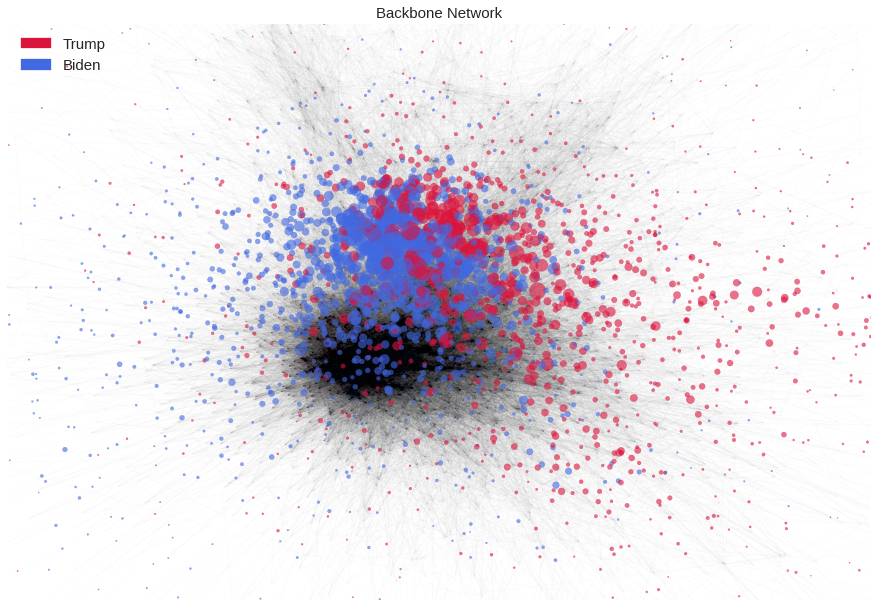

In [ ]:
fig = plt.figure(figsize=(12, 8))
nx.drawing.nx_pylab.draw(B, node_color=color_map, node_size=node_sizes, with_labels=False, edge_color="white", alpha=.6)
nx.drawing.nx_pylab.draw(B, node_color=color_map, node_size=node_sizes, with_labels=False, edge_color="black", alpha=.01)
plt.title("Backbone Network", fontsize=15)
t_patch = mpatches.Patch(color="crimson", label="Trump")
b_patch = mpatches.Patch(color="royalblue", label="Biden")
plt.legend(handles=[t_patch, b_patch], loc="best", fontsize=15)
plt.ylim((-0.05, 0.05))
plt.xlim((-0.05, 0.05))
plt.show()

From the network illustration it can be seen that there seem to be a tendency that the the blue Biden nodes cluster to the left in the plot while the red Trump nodes cluster to the right in the plot. This suggests that we should be able to make some differentiating among the users when considering this way of classifying our users. 

### 3.2.2 Classifying users with community Detection and sentiment analysis
- Motive: "Classifying users by from_subreddit is not necessarily optimal.
- Tools: Three compared partitions: from_subreddit, Louvain and sentiment in comment. Modularity. Plots
- Results: Modularity=... Plots=... #Links_Across_partition=..., MORE to decide the better partition!!?
- Discussion: From X and Y we find __ as the best partitioning for representing each candidates' supporters

### TBD: 3.2.3 Detecting communities with the bipartite network? ONLY MAYBE!
- Motive: "Bipartite networks might contain additional information, which is discarded in the projection
- Tools: "Explain how community detection works"...
- Results: "We saw a lot more!!" or "revealed nothing..."
- Discussion: "Probably because..."

## 3.3 Comparing candidate sub-networks (of best partitioning)



### 3.3.1 Simple Network Statistics for candidate sub-networks
- Motive: "To compare the two networks in terms of simple statistics"
- Tools: #Nodes, #Edges, Degrees, densities, median, mode, 
- Results: "compute them..."
- Discussion: "This could mean that... "


### 3.3.2 Degree Distributions and the Network types
- Motive: "To understand the characteristics of our networks... Does our network follow power-law? Which could mean..."
- Tools: explain theory...
- Results
- Discussion

### 3.3.3 Advanced statistics (maybe this should be 3 seperate bullets)
- Motive: "Which supporters are more diverse in interests? which are etc...
- Tools: Clustering, Shortest paths and centralities in sub-networks?
- Results
- Discussion

### 3.3.4 Community detection wihin partitions
- Motive: "Investigate if any communities within Biden/trump lair"
- Tools: Louvain
- Results
- Dicussion

## 3.4 Comparing text/comments of candidates' supporters/subreddit forum users 

### 3.4.1 Natural Language Processing
- Motive: Is one community more eloquent? Does either community have more catch-phrases? Typical words?
- Tools: Lexical diversity, collocations, TFTR + wordclouds
- Results
- Discussion


### 3.4.2 Sentiment analysis
- Motive: Is one candidate´s supporters more positive than the other's?
- Tools: Sentiment analysis of comments
- Results
- Discussion

# 4 Discussion. Think critically about your creation
- What went well?,
- What is still missing? What could be improved?, Why?
  - Improvements: Maybe also try to incooporate how *often* the users have commented on the same subreddit in link weights.
  - Improvements: We could also try to base weights of user links equal to frequency of common subreddits. I.e. if [trump, trump, ask reddit, dogs] and [trump, trump, ask reddit, cats] should yield weight 3!

# 5 Contributions. Who did what?
- You should write (just briefly) which group member was the main responsible for which elements of the assignment. (I want you guys to understand every part of the assignment, but usually there is someone who took lead role on certain portions of the work. That’s what you should explain).

- It is not OK simply to write "All group members contributed equally".

